# Mini Projet 2 Parcimonie
# Antonin GAY



## Introduction


In [1]:
# Line to correct importations
import os
print(os.getcwd())
os.chdir('..')
print(os.getcwd())


C:\Users\Antonin\PycharmProjects\tp-parcimonie\MiniProjet
C:\Users\Antonin\PycharmProjects\tp-parcimonie


In [2]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import MiniProjet.src.plot as plot
%matplotlib inline


### Notations


Les données qui sont dans l'espace de Fourier seront notées en majuscule par convention, tandis que celles dans le 
domaine réel seront notées en minuscules. Soit : 

$$ X = \mathcal{F} (x) $$

Et :

$$ x = \mathcal{F}^{-1} (X) $$




### Description des données

Les données d'origines, que nous souhaitons récupérer, sont des données multi-channels notées $x$. Elles peuvent être 
décomposées comme la combinaison linéaire de deux composantes astrophysiques : le synchrotron, noté $sync$, et 
les émissions de poussières, notées  $dust$. Ces deux composantes sont supposées parcimonieuses dans le domaine 
des ondelettes (starlets).

Ces données, que l'on souhaite obtenir, sont mesurées. Il s'y ajoute alors un bruit blanc gaussien $n$, indépendant 
entre les canaux. Afin d'obtenir ses paramètres, des réalisations de ce bruit nous sont fournies pour chaque canal 
(évidemment, il ne s'agit pas de la même réalisation que celle ajoutée sur les données).

Les données bruitées sont ensuite mesurées dans le domaine de Fourier. On mesure alors $X_n$ qui est la représentation 
des données bruitées dans l'espace de Fourier.

Finalement, les données fournies, notées $B$, sont des mesures incomplètes des données $X_n$ dans l'espace de 
Fourier. Ces données cont incomplètes car ils manquent une partie des échantillons, qui valent alors 0. Les masques 
correspondants à ces données manquantes sont fournis aussi, ce qui nous permet de connaître leur position.

Les données $X_n$, tout comme $B$ sont alors des données complexes.

On pourrait résumer le problème sous cette forme :

$$B = X_n[mask] = \mathcal{F}(x + n)[mask] = \mathcal{F}(\alpha * dust + \beta * sync + n)[mask]$$

Avec $dust$ et $sync$ parcimonieux dans l'espace des ondelettes (starlets).




## Premières observations des données

### Premier exemple

La figure suivante montre le premier canal des données $B$, ainsi que le masque correspondant. On rappelle que le 
masque est composé de 0 et de 1 et a été multiplié à $X_n$ pour obtenir $B$. Les points lumineux sur la représentation 
du masque correspondent ainsi aux 1 et donc aux valeurs conservées. 


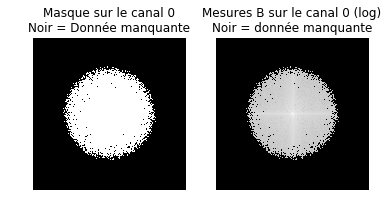

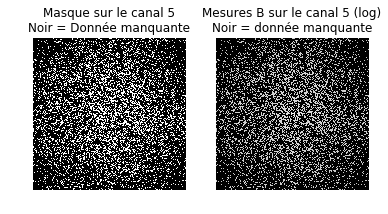

In [3]:
B = loadmat('MiniProjet/RadioInterferometry_MAT/Fourier_Measurements.mat')['B']
masks = loadmat('MiniProjet/RadioInterferometry_MAT/Fourier_Sampling.mat')['mask']

plot.mask_b_1chan(masks, B, 0)
plot.mask_b_1chan(masks, B, 5)


In [4]:

print('Proportions de données masquées par channel')

for i in range(10):
    print('\tChannel n#%d\t%d%% masquées' % (i, 100 * (1 - masks[i].mean())))


Proportions de données masquées par channel
	Channel n#0	62% masquées
	Channel n#1	63% masquées
	Channel n#2	64% masquées
	Channel n#3	64% masquées
	Channel n#4	62% masquées
	Channel n#5	62% masquées
	Channel n#6	62% masquées
	Channel n#7	63% masquées
	Channel n#8	62% masquées
	Channel n#9	63% masquées



On observe avec ces deux exemples plusieurs choses. Premièrement, la proportion de données masquées par canal est 
importante (et constante), avec deux tiers des données manquantes. Deuxièmement, la répartitions des données manquantes
n'est pas constante d'un canal à l'autre, et l'exemple précédent montre bien que le premier canal se retrouve avec ses 
hautes fréquences coupées, tandis que la répartition est plus aléatoire sur le canal 5, bien qu'encore légèrement 
plus importante au centre.

### Observation des données sur tous les canaux 

Sur les figures suivante, nous affichons les masques et mesures sur les dix canaux afin d'en avoir une meilleure 
représentation.


Masques, dans le domaine de Fourier


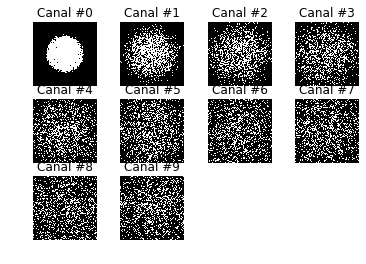

In [5]:

print('Masques, dans le domaine de Fourier')
plot.mask_10chan(masks)


In [6]:

print('Mesures, dans le domaine de Fourier')
plot.b_10chan(B)


Mesures, dans le domaine de Fourier



On se rend rapidement compte avec ces figures d'un premier problème, à la fois pour la visualisation des mesures et 
pour leur interprétation : les valeurs masquées étant bien plus faibles que celles non-masquées, elles nous empêche de 
voir les faibles variations des données des mesures. Cependant, cela pourrait ne pas déranger la transformée inverse,
que nous allons tester, sur ces premières valeurs, pour observer l'effet du masque sur les données.



### Transformée inverse sans inpainting


In [7]:

# On définit une fonction qui calcule la transformée inverse des 10 canaux

def ifft_10chan(b):
    x = np.zeros(shape=b.shape)
    
    for idx in range(10):
        # On calcule la transformée inverse pour chaque canal
        x[:, :, idx] = np.fft.ifft2(b[:, :, idx])
    return x


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


(-0.5, 255.5, 255.5, -0.5)

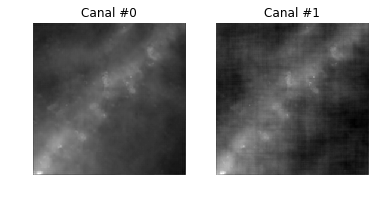

In [8]:
x_n = ifft_10chan(B)
plot.x_10chan(x_n)

plt.figure()
plt.subplot(121)
plt.imshow(x_n[:,:,0], cmap='gray')
plt.title('Canal #0')
plt.axis('off')

plt.subplot(122)
plt.imshow(x_n[:,:,1], cmap='gray')
plt.title('Canal #1')
plt.axis('off')

plt.figure()
plt.subplot(121)
plt.imshow(x_n[:,:,5], cmap='gray')
plt.title('Canal #5')
plt.axis('off')

plt.subplot(122)
plt.imshow(x_n[:,:,9], cmap='gray')
plt.title('Canal #9')
plt.axis('off')



Ces premiers résultats montrent déjà quelques effets. Premièrement, les données manquantes ne détruisent pas totalement 
l'information présente dans les images d'origine, puisqu'on peut retrouver dans ces images des formes astrologiques qui 
sont celles que l'on va rechercher. Ensuite, on observe sur certains canaux (notamment le #1 et #5 sur la figure 
ci-dessus) des artefact sous la forme d'une grille sur l'image. Ceci pourrait être dû aux masques, notamment si ils ne 
laissent dans certaines direction du Fourier que certaines composantes, jouant alors un rôle important dans la 
propagation de formes régulières et dirigées.



### Première séparation de sources

A partir de ces premières données, nous allons essayer de réaliser une séparation de sources, afin d'obtenir une 
première estimation de nos deux sources originales. Dans un premier temps, nous allons utiliser l'algorithme FastICA,
étudié dans le troisième TP du cours. Si il n'est pas l'algorithme qui obtenait les meilleurs résultats pour toutes les
applications, il était tout de même plutôt régulier, et conviendra pour ce premier essai.


In [9]:

from TP3.pyBSS import perform_fast_ica

def fast_ica_mini_projet(x):
    # Mise en forme de x pour les algorithmes
    x_flat = np.zeros(shape=(10, 256**2))
    for idx in range(10):
        x_flat[idx] = x[:, :, idx].flatten()
    
    # On estime les sources puis on les remet dans un format d'image
    a_est, sources_est = perform_fast_ica(x_flat, 2, do_whitening=True)
    sources_est = np.reshape(sources_est, newshape=(2, 256, 256))
    
    return sources_est


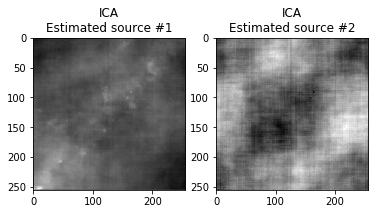

In [10]:

sources_est_ica = fast_ica_mini_projet(x_n)
plot.sources_est_2(sources_est_ica, title='ICA')



Le résultat de cette opération change évidemment avec chaque exécution, néanmoins, ils restent globalement les mêmes.

On observe ainsi que l'algorithme sépare les rayures que nous observions précédemment et le reste du signal, de manière 
plus ou moins efficace. Cependant, si ces rayures sont bien dues aux données manquantes dans l'espace de Fourier, 
alors cette séparation, bien que plutôt viable, n'est pas celle désirée. De plus, on observe sur la 'source' 
correspondant aux rayures des formes qui semblent correspondre à des information astrophysiques, qui ne devraient pas 
être supprimée de la sorte.

Enfin, cet algorithme n'est que peu efficace contre le bruit, qui n'est pas éliminé.



### Forme du bruit

Afin de finir cette première partie d'observations des données, nous allons rapidement observer l'allure du bruit, que 
nous n'avons pas utilisé dans cette première approche naïve, mais qui pourrait éventuellement servir par la suite.

La figure suivante affiche donc les 10 réalisations de bruit fournies, et liste ensuite ses propriétés importantes.


Caractéristiques des bruits
	Canal #0	mean = -1.4E-06		std = 2.11E-03
	Canal #1	mean = 1.5E-05		std = 2.23E-03
	Canal #2	mean = -1.3E-05		std = 2.44E-03
	Canal #3	mean = -2.6E-08		std = 2.65E-03
	Canal #4	mean = 8.1E-06		std = 2.84E-03
	Canal #5	mean = 1.2E-05		std = 3.12E-03
	Canal #6	mean = 6.4E-07		std = 3.52E-03
	Canal #7	mean = 3.8E-06		std = 4.13E-03
	Canal #8	mean = 4.4E-05		std = 5.03E-03
	Canal #9	mean = 3.9E-05		std = 6.11E-03


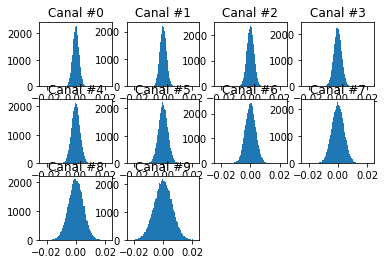

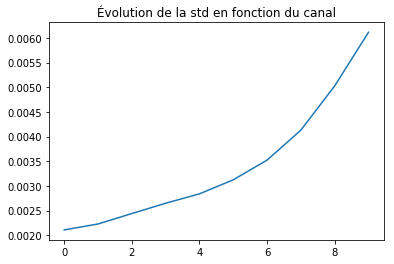

In [11]:

N = loadmat('MiniProjet/RadioInterferometry_MAT/Noise_single_simulation.mat')['noise2']

plot.n_10chan(N)

print('Caractéristiques des bruits')
std_list = []
for i in range(10):
    n_i = N[:,:,i]
    print('\tCanal #%d\tmean = %.1E\t\tstd = %.2E' % (i, n_i.mean(), n_i.std()))
    std_list.append(n_i.std())

plt.figure()
plt.plot(std_list)
plt.title('Évolution de la std en fonction du canal')
plt.show()



Les bruits sont donc visiblement tous gaussiens, de moyenne nulles, mais leurs déviations standard sont différentes, 
augmentant avec le numéro du canal (le premier canal a la plus faible, le dernier la plus élevée). Ces informations
pourraient éventuellement être utilisées lors du débruitage.


## Amélioration de la séparation de source grâce à la Parcimonie

Une solution pour améliorer la séparation des sources est de prendre en compte l'information que nous possédons sur
la parcimonie des deux sources dans le domaine des ondelettes. Au vu de la forme des données, nous admettrons que cette
parcimonie est dans le domaine des starlets, régulièrement utilisé lors des TP.

En utilisant cette information à priori, nous allons pouvoir améliorer la séparation de source, en utilisant 
l'algorithme GMCA, utilisé dans le TP3 du cours, qui a la particularité d'être particulièrement efficace pour 
séparer des sources parcimonieuses. En effet, le GMCA essaie d'obtenir des sources qui soient parcimonieuses lors de 
son exécution. L'optimisation se fait en minimisant l'erreur d'estimation et la parcimonie des sources obtenues, ce qui
a pour effet de trouver un compromis entre des sources correspondant parfaitement aux données d'origine et des sources 
les plus parcimonieuses possibles. Ainsi, des sources très parcimonieuses seront plus facilement retrouvées.

Cela a aussi pour effet d'élimner efficacement le bruit, qui n'est pas parcimonieux dans l'espace des starlets, et qui
ne sera pas gardé par l'algorithme.

Pour appliquer cet algorithme, nous devons donc dans un premier temps passer nos données dans l'espace des starlets, 
puis les séparer via l'algorithme GMCA.


In [12]:

from TP3.Starlet2D import starlet_forward_2d, starlet_backward_2d
from TP3.pyBSS import perform_gmca

def gmca_mini_projet(x, j=5):
    # Forward Starlet transform of the 10 channels
    c_list = []
    w_list = []
    for idx in range(10):
        c, w = starlet_forward_2d(x[:, :, idx], j=j)
        c_list.append(c)
        w_list.append(w)
    
    # Flattening data for GMCA
    len_c = 256 * 256
    len_w = 256 * 256
    x_flatten = np.zeros(shape=(10, len_c + j * len_w))
    for idx in range(10):
        c = c_list[idx]
        w = w_list[idx]
        x_flatten[idx][0:len_c] = c.flatten()
    
        w_transp = np.transpose(w, [2, 0, 1])
        x_flatten[idx][len_c:] = w_transp.flatten()
    
    # GMCA
    a_est_star, sources_est_star, _ = perform_gmca(x_flatten, 2)
    
    # Backward Starlets to get the images of the two sources
    sources_est = np.zeros((2, 256, 256))
    for idx in range(2):
        source = sources_est_star[idx]
        c = np.reshape(source[0:256 ** 2], (256, 256))
    
        w_transp = np.reshape(source[256 ** 2:], (5, 256, 256))
        w = np.transpose(w_transp, [1, 2, 0])
    
        sources_est[idx] = starlet_backward_2d(c, w)
    
    return sources_est


In [13]:

sources_est_gmca = gmca_mini_projet(x_n, j=5)
plot.sources_est_2(sources_est_gmca, title='GMCA')



L'utilisation du GMCA offre de bien meilleurs résultats qu'avec l'algoritme précédent, le FastICA. Quand il est 
appliqué sur les données sans inpainting sur le Fourier, il élimine même le quadrillage considéré ici comme du bruit, 
que l'on pouvait voir sur les résultats du FastICA. Cela est dû au fait que cet artefact n'a pas une représentation
parcimonieuse dans le domaine des starlets et est donc éliminé par l'algorithme.

Néanmoins, ces résultats sont loins d'être parfaits, notamment les deux sources semblent être encore mélangées. Cela 
pourra être amélioré par la prochaine partie de la résolution du problème.

La figure suivante compare les résultats obtenus par le GMCA et le FastICA.


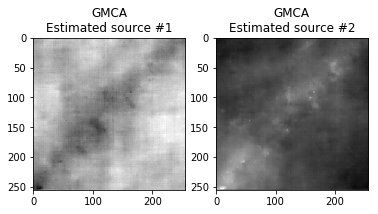

In [22]:

sources_est_ica = fast_ica_mini_projet(x_n)
plot.sources_est_2(sources_est_ica, title='ICA')

sources_est_gmca = gmca_mini_projet(x_n, j=5)
plot.sources_est_2(sources_est_gmca, title='GMCA')


## Inpainting dans l'espace de Fourier


### Première solution naïve

Une première solution naïve et simple pour remplacer les données manquantes est de les remplacer par la valeur moyenne 
des données présentes. En supposant que les données manquantes avaient une distribution proche de celles présentes 
(particulièrement vrai dans le cas où le masque aurait une distribution uniforme), cette solution minimise l'erreur 
d'estimation, surtout par rapport à la solution précédemment mise en place, qui consistait à laisser ces valeurs à zéro.

Cependant, avant d'appliquer cette méthode, on peut observer sur les différents masque (cf. Figure ci-dessous) que 
l'hypothèse de distribution uniforme n'est pas toujours respectée, notamment sur le premier canal, où toutes les hautes 
fréquences ont été supprimées. Ainsi, utiliser cette méthode risquerait de biaiser de manière importante nos données, 
en ajoutant un fort "bruit" là où il n'y a potentiellement aucunes données.


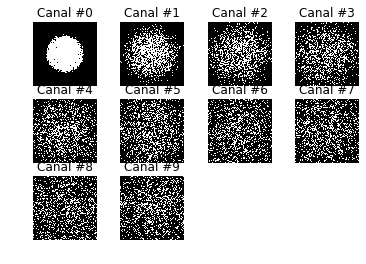

In [15]:

plot.mask_10chan(masks)


In [16]:

B_interp_1 = B.copy()
for i in range(4, 10):
    b_i = B[:,:,i]
    m_i = masks[:,:,i]
    b_mean = (b_i[m_i == 1]).mean()
    B_interp_1[:,:,i] = b_i + (1 - m_i) * b_mean 


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


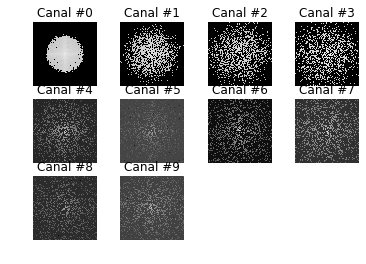

In [17]:

plot.b_10chan(B_interp_1)

sources_est_interp_1 = gmca_mini_projet(ifft_10chan(B_interp_1), j=5)
plot.sources_est_2(sources_est_interp_1, title='Mean Interpolation')



Malheureusement, mais comme on pouvait s'y attendre, cette solution n'améliore pas la solution, ajoutant trop de bruits 
aux données, qui en perdent leur consistance spatiale


### Image inpainting

#### De la difficulté d'un inpainting complexe
La seconde solution consiste à appliquer un algorithme d'inpainting d'image sur notre transformée de Fourier. Cependant,
la difficulté vient du fait que ce données sont complexes, alors que la majorité des algorithmes sont adaptés à des 
images dont les valeurs sont réelles, et cohérentes dans l'espace. Cette difficulté vient de l'aspect
quasiment aléatoire de la phase de la transformée de Fourier : si le module est cohérent sur de faibles distances, la
phase ne l'est quasiment pas. 

Les exemples ci-dessous, tirées d'une image classique afin d'avoir une transformée de 
Fourier complète, montrent bien cet effet sur la phase. On l'observe donc aussi sur les valeurs des parties réelles et 
imaginaires.


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


(-0.5, 511.5, 511.5, -0.5)

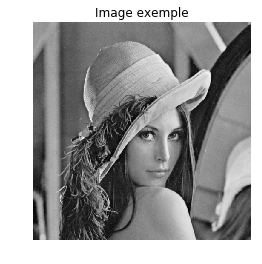

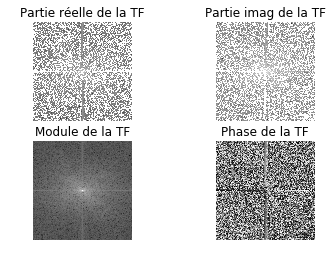

In [18]:

import imageio
im = imageio.imread('MiniProjet/Lenna_(test_image).png')
im = np.mean(im, axis=2)

im_fft = np.fft.fft2(im)

im_real = np.real(im_fft)
im_im = np.imag(im_fft)

im_norm = np.abs(im_fft)
im_phase = np.angle(im_fft)

plt.figure()
plt.imshow(im, cmap='gray')
plt.title('Image exemple')
plt.axis('off')

plt.figure()
plt.subplot(221)
plt.imshow(np.fft.fftshift(np.log(im_real)), cmap='gray')
plt.title('Partie réelle de la TF')
plt.axis('off')

plt.subplot(222)
plt.imshow(np.fft.fftshift(np.log(im_im)), cmap='gray')
plt.title('Partie imag de la TF')
plt.axis('off')

plt.subplot(223)
plt.imshow(np.fft.fftshift(np.log(im_norm)), cmap='gray')
plt.title('Module de la TF')
plt.axis('off')

plt.subplot(224)
plt.imshow(np.fft.fftshift(im_phase), cmap='gray')
plt.title('Phase de la TF')
plt.axis('off')



#### Tentative naïve d'inpainting complexe

Malgré cette difficulté, nous allons tenter de réaliser cet inpainting à l'aide d'un algorithme classique, et observer 
les résultats obtenus. Ces algorithmes se basant sur des méthodes par patch pourraient réussir à obtenir de bons 
résultats, malgré la complexité du problème.

Nous utilisons la méthode d'inpainting fournie par la librairie OpenCV, basée sur l'article [1], qui utilise des 
équations différentielles inspirées de la mécanique des fluides pour réaliser un inpainting des pixels manquants. Nous
réalisons alors un inpainting sur le module et sur la phase, avant de reconstruire l'image complexe.

Comme précédemment, nous ne faisons pas l'inpainting sur le premier canal, dont les données sont manquantes sur de trop 
grandes zones de données, et qui risquerait de créer trop de bruit.


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


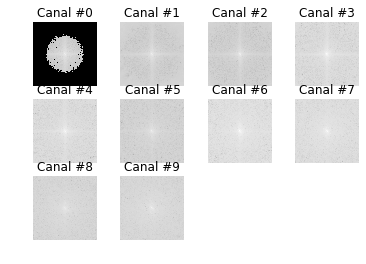

In [19]:

import cv2

B_inpaint = B.copy()
for i in range(1, 10):
    b_i = B[:, :, i]
    m_i = 1 - masks[:, :, i]
    
    b_abs = np.abs(b_i)
    b_phase = np.angle(b_i)

    b_abs = b_abs.astype(np.float32)
    b_phase = b_phase.astype(np.float32)

    b_abs_inp = cv2.inpaint(b_abs, m_i, 3, cv2.INPAINT_TELEA )
    b_phase_inp = cv2.inpaint(b_phase, m_i, 3, cv2.INPAINT_TELEA )

    B_inpaint[:, :, i] = b_abs_inp * np.exp(1j * b_phase_inp)

plot.b_10chan(B_inpaint)   

plot.x_10chan(ifft_10chan(B_inpaint))


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


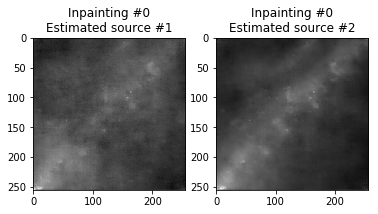

In [23]:

sources_est_inp = gmca_mini_projet(ifft_10chan(B_inpaint), j=5)
plot.sources_est_2(sources_est_inp, title='Inpainting #0')



Ces résultats ne sont malheureusement pas aussi bons qu'espérés, probablement majoritairement à cause de l'interpolation
de la phase, qui reste un exercice trop complexe pour les algorithmes d'inpainting classiques. Néanmoins, on observe 
tout de même la suppression des artefacts en forme de grille observés précédemment, et qui étaient en effet dus aux 
transformées de Fourier incomplètes. 

Afin d'obtenir de meilleurs résultats à l'aide de méthodes d'inpainting, il faudra donc se tourner vers des méthodes 
adpatées aux valeurs complexes, ce à quoi s'intéresse la prochaine partie.


### Littérature

Dans la littérature, plusieurs articles présentent des méthodes et algorithmes pour réaliser l'inpainting sur les 
données complexes. Premièrement, Borzi et al. dans [2] présentent un algorithme permettant de retrouver la phase 
d'images complexes à partir de diffusion et d'inpainting. Leur méthode est appliquée à des images SAR (Radar à synthèse 
d'ouverture, RSO en français, mais SAR dans la langue de Shakespeare) qui sont des images complexes obtenues par des
satellites radar. Elle se base sur la résolution de l'équation de la diffusion de Ginzburg–Landau, développée pour
des problèmes physiques mais adaptée avec succès à des problèmes d'images dans des articles précédents cités par 
l'article. Cette première méthode permet d'obtenir de premiers bons résultats, néanmoins, la phase qui est étudiée a 
une forme plus régulière que celles présentée dans nos problèmes.

La seconde solution potentielle est proposée par Li et Zeng dans l'article [3]. Cette fois-ci, il s'agit de deux 
méthodes et mise en place algorithmiques spécifiquement développées pour les cas d'inpainting de transformée de Fourier
incomplètes. Leur solution semble offrir de bons résultats sur les exemples fournis dans l'article. Il s'agirait alors 
d'implémenter leur méthode et de la tester sur nos données, qui pourrait alors offrir une meilleure interpolation
que les méthodes précédemment utilisées.

Cependant, majoritairement par manque de temps, cette solution n'a pas pu être mise en oeuvre et testée, et devra rester
dans la catégorie des solutions potentielles.


## Résolution d'équations via algorithmes proximaux

Une dernière solution qui pourrait être mise en place pour réaliser la séparation de nos sources dans cette application
serait de résoudre tous nos problèmes d'un coup via la minimisation d'une norme précise, de la forme :

$$ \text{argmin}_{dust, sync} ||\mathcal{F}(dust + sync) - B||_2^2 + ||\Phi * dust||_{l_0} + ||\Phi * sync||_{l_0}$$

Avec : 
 - $B$ Nos mesures dans Fourier
 - $\Phi$ L'opérateur de la transformée en starlets
 - $dust$ La composante "émission de poussières" du signal 
 - $sync$ La composante "synchrotron" du signal
 
Cela pourrait être résolu à l'aide d'algorithmes proximaux, tels qu'étudiés durant le cours, mais nécessiterait de 
s'inquiéter de la convexité du problème et de la convergence des algorithmes.

Cependant, majoritairement par manque de temps, cette solution n'a pas pu être mise en oeuvre et testée, et devra rester
dans la catégorie des solutions potentielles.
 


## Conclusion

Ce mini-projet consistait à réaliser une séparation de sources dans un cas assez complexe. Les données d'origines, 
considérées comme une combinaison linéaire de deux signaux parcimonieux en starlets, étaient mesurées, bruitées, dans 
l'espace de Fourier. Ces mesures étaient néanmoins incomplètes, ce qui était simulé par l'application d'un masque sur
ces mesures, imposant deux tiers des valeurs des transformées à 0.

L'objectif était alors de retrouver les deux signaux astrophysiques d'origine à partir des mesures bruitées incomplètes 
dans le domaine de Fourier.

Une première observation naïve nous donna une première estimation, visiblement grossière, des données. Celles-ci furent 
obtenues par une transformée inverse des données incomplètes, suivie par une séparation de source via une 
_Independant Components Analysis_. Cette approche sera appelée _ICA_ dans les figures suivantes.

Ensuite, la partie estimation de sources fut améliorée par la prise en compte de la parcimonie des sources. Pour cela, 
les données à séparer furent passées dans le domaine des starlets, où les sources devaient être parcimonieuses, et 
l'algorithme GMCA, particulièrement efficace sur des sources parcimonieuses, fut utilisé. Cette approche améliora 
grandement les données, en supprimant notamment une partie du bruit. Cette approche sera notée _GMCA_.

Enfin, une dernière amélioration fut apportée par une tentative d'inpainting des données manquantes dans le domaine de 
Fourier. La principale difficulté de cet inpainting venait du fait que les données étaient complexes. La phase étant
très peu cohérente localement, elle est alors très difficile à interpoler pour un algorithme d'inpainting. Deux 
méthodes furent utilisées, la plus efficace, même si loin d'être fantastique, sera notée _Inpainting_.

Les résultats de ces trois approches sont affichés, dans l'ordre, sur la Figure ci-dessous :


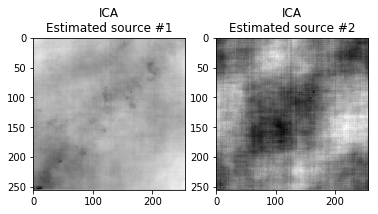

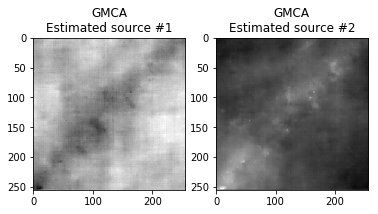

In [24]:

plot.sources_est_2(sources_est_ica, title='ICA')
plot.sources_est_2(sources_est_gmca, title='GMCA')
plot.sources_est_2(sources_est_inp, title='Inpainting')



Ces images confirment néanmoins que les résultats allaient en s'améliorant, les sources étant de plus en plus claires 
et débruitées. Néanmoins, elles restent corrélées jusqu'au bout, alors qu'elles devraient être indépendantes.

Deux solutions ultérieures possibles furent ensuite évoquées. La première, basée sur les articles [2, 3] consiste à 
utiliser des algorithmes d'inpainting adaptés à l'interpolation de données complexes. Même si celles-ci sont difficile 
à obtenir, ces méthodes pourraient permettre une grande amélioration des résultats. La deuxième serait d'utiliser un 
algorithme proximal pour résoudre l'équation de minimisation complète, et résoudre ainsi les deux faces du problème
en même temps.

Enfin, il n'a pas été pris en compte dans ce rapport les formes et distributions du bruit qui étaient fournies. Il 
serait donc probablement possible d'améliorer les résultats et estimations en prenant en compte ses informations. 
Celles-ci pourraient par exemple probablement être incorporées à l'équation à minimiser avec l'algorithme proximal.

Cependant, majoritairement par manque de temps, ces solutions n'ont pas pu être mises en oeuvre et testées dans le
cadre de ce projet.

## Bibliographie

[1] M. Bertalmio, A. L. Bertozzi, et G. Sapiro, « Navier-stokes, fluid dynamics, and image and video inpainting », 
in Proceedings of the 2001 IEEE Computer Society Conference on Computer Vision and Pattern Recognition. 
CVPR 2001, Kauai, HI, USA, 2001, vol. 1, p. I-355-I‑362.

[2]A. Borzi, M. Di Bisceglie, C. Galdi, L. Pallotta, et S. L. Ullo, « Phase retrieval in SAR interferograms using 
diffusion and inpainting », in 2010 IEEE International Geoscience and Remote Sensing Symposium, Honolulu, HI, USA, 
2010, p. 2912‑2915.

[3]F. Li et T. Zeng, « A New Algorithm Framework for Image Inpainting in Transform Domain », SIAM Journal on 
Imaging Sciences, vol. 9, nᵒ 1, p. 24‑51, janv. 2016.
